In [15]:
from Py2P.core import *
from Py2P import sync,plot

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
datapaths = ['rec_000\\suite2p\\plane0\\',
             'rec_001\\suite2p\\plane0\\']
             
syncfiles = ['rec_000\\rec_000_000.mat',
             'rec_001\\rec_000_001.mat']
             
sequencefile = ['rec_000\\stim_dict.json',
                'rec_001\\stim_dict.json']
                

trials_names = {0:"IPSI",1:"CONTRA",2:"BOTH"}

In [17]:
# generate synchro objects
synchros = []

for syncfile,seq in zip(syncfiles,sequencefile):

    synchro = sync.Sync()
    synchro.generate_data_structure(syncfile,seq,trials_names)
    synchros.append(synchro)

# generate data_dict
data_dict = {d:s for d,s in zip(datapaths,synchros)}
print(data_dict)

In [18]:
# generate batch object and retrive cells
batch = Batch2P(data_dict)

batch.load_params
cells = batch.get_cells()

{'rec_002\\suite2p\\plane0\\': <two_phan.sync.Sync object at 0x00000202837675B0>, 'rec_003\\suite2p\\plane0\\': <two_phan.sync.Sync object at 0x00000202FD7866D0>}
> Using the parameters file found in data_path.

> loading data from rec_002\suite2p\plane0\ ... OK
> Using the parameters file found in data_path.
> parameters loaded.

> loading data from rec_003\suite2p\plane0\ ... OK
> Using the parameters file found in data_path.
> parameters loaded.

> Extracting cells ...


100%|██████████| 1111/1111 [00:04<00:00, 242.34it/s]


> 144 responsive cells found (tot: 1111, keep_unresponsive: False)

> Extracting cells ...


100%|██████████| 1001/1001 [00:04<00:00, 239.74it/s]

> 191 responsive cells found (tot: 1001, keep_unresponsive: False)


c:\Users\micheli\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\micheli\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
c:\Users\micheli\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


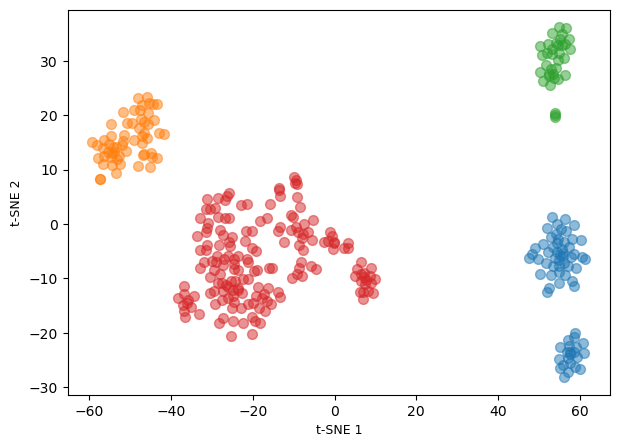

In [19]:
### analyze and plot populations ###

pops = batch.get_populations(stims_names=["chirp"],
                           trials_names=None, 
                           n_clusters=4, 
                           use_tsne=True,
                           type='dff', 
                           normalize='z', 
                           plot=True)

plt.savefig("PCA_populations.png")

In [ ]:
### plot ###

import numpy as np

# ## plot FOVs
# plot.plot_FOV(pops, rec, k=3)

ordered_trials = sorted(list(trials_names.values()))
stim_names = list(batch.stims_trials_intersection.keys())

for id,pop in enumerate(pops):

    save_path = "POPULATION_#%d"%id

    if os.path.isdir(save_path):

        shutil.rmtree(save_path)

    os.mkdir(save_path)

    pop_cells = [cells[c] for c in pop]

    ### plot heatmap

    fig, axs = plt.subplots(len(trials_names),len(stim_names),figsize=(10,15))

    fig.suptitle('POPULATION #%d, N:%d'%(id,len(pop_cells)), fontsize=16)

    for i,trial in enumerate(ordered_trials):

        for j,stim in enumerate(stim_names):

            if not isinstance(axs, np.ndarray):

                ax = axs

            elif len(stim_names)==1:

                ax=axs[i]

            elif len(ordered_trials)==1:

                ax=axs[j]

            else:
                ax=axs[i,j]


            if trial in synchro.sync_ds[stim]:


                plot.plot_averages_heatmap(pop_cells, 
                                            synchro, 
                                            stims=stim, 
                                            trials=trial, 
                                            type='dff', 
                                            stim_bar=False,
                                            vmin=None, 
                                            vmax=None, 
                                            normalize='z', 
                                            cb_label="\u0394F/F (z-score)",
                                            ax=ax)

            else:

                ax.axis("off")

            if i == 0: ax.set_title(stim,fontsize=20)

    if len(ordered_trials)>1:

        for ax, trial in zip(axs, ordered_trials):

            ax[0].set_ylabel(trial,fontsize=18)
    else:

        ax.set_ylabel(trial,fontsize=18)

    plt.savefig("%s\\heatmaps_dff.png"%save_path, bbox_inches="tight")
    plt.close(fig)

    ###
    #plot full heatmap
    fig, axs = plt.subplots(1,figsize=(10,7))
    fig.suptitle('POPULATION #%d, N:%d'%(id,len(pop_cells)), fontsize=16)

    plot.plot_averages_heatmap(pop_cells,
                                synchro,
                                full="dff",
                                vmin=None, 
                                vmax=None, 
                                normalize='z', 
                                cb_label="\u0394F/F (z-score)", 
                                stim_bar=False,
                                ax=axs)
    
    plt.savefig("%s\\full_heatmap_dff.png"%save_path, bbox_inches="tight")
    plt.close(fig)

    ### plot averaged responses

    plot.plot_multipleStim(pop_cells, 
                           synchro, 
                           average=True, 
                           save=True, 
                           save_path=save_path, 
                           stims=None, 
                           trials=None, 
                           full='dff',
                           share_x=False, 
                           share_y=False,
                           group_trials=False, 
                           legend=True)


    ### plot all the cells

    save_path_allcells = save_path+"\\all_cells"

    if os.path.isdir(save_path_allcells):

        shutil.rmtree(save_path_allcells)

    os.mkdir(save_path_allcells)

    plot.plot_multipleStim(pop_cells, 
                           synchro, 
                           average=False, 
                           save=True, 
                           save_path=save_path_allcells, 
                           stims=None, 
                           trials=None, 
                           full='dff',
                           share_x=False, 
                           share_y=False,
                           group_trials=False, 
                           legend=True)
    